In [1]:
!pip install econml

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
# Some imports to get us started
# Utilities
import os
import urllib.request
import numpy as np
import pandas as pd

# Generic ML imports
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import (Lasso, LassoCV, LogisticRegression,
                                  LogisticRegressionCV,LinearRegression,
                                  MultiTaskElasticNet,MultiTaskElasticNetCV)
# EconML imports
from econml.dml import LinearDML, CausalForestDML, SparseLinearDML, DML
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter

import matplotlib.pyplot as plt

%matplotlib inline
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image,display

import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures

import dowhy
from dowhy import CausalModel

from econml.iv.dr import LinearIntentToTreatDRIV

In [3]:
#读取文件
data=pd.read_excel('2018-2020final.xlsx')

In [4]:
#查看是否有空值
data.isnull().sum().sort_values(ascending=False)

years          0
hotel          0
square         0
hunman         0
factory        0
school         0
office         0
shop           0
hospital       0
theater        0
score          0
park           0
restaurant     0
edu            0
Health care    0
life           0
scenry         0
transport      0
land           0
dtype: int64

In [5]:
#将每一行得分值*100不然计算因果值太低

data['score'] = data['score']*100

In [6]:
# Define estimator inputs
#定义第一个关于"human"的因果效应
Y = data["score"]  # outcome of interest
#print('Y的类型：',type(Y))
T_human = data["hunman"]  # intervention, or treatment
X_human = data.drop(columns=["score", "hunman","land","years"])


In [7]:
#定义模型，
est_Forest_human = CausalForestDML(
    model_y=GradientBoostingRegressor(),
    model_t=GradientBoostingRegressor(),
    criterion='mse', n_estimators=1000,
                       min_impurity_decrease=0.001,
    #model_final=Lasso(alpha=0.1, fit_intercept=False),
    featurizer=PolynomialFeatures(degree=2, include_bias=False),
    random_state=123
  )
est_Forest_human = est_Forest_human.dowhy.fit(Y, T=T_human, X=X_human)

print('score:',est_Forest_human.score)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


score: <bound method _RLearner.score of <econml.dml.causal_forest.CausalForestDML object at 0x7f72a7dd66d0>>


[1.0012046  1.36035819 1.26404865 1.30100144 1.27161998 1.26877779
 1.28985618 1.27771811 1.08448192 1.21293035 1.32404847 1.12834968
 1.27459002 1.2122324  1.16435006 1.11808446 1.0012046  1.37646185
 1.34879368 1.21406079 1.36705949 1.18754448 1.24075778 1.23457179
 1.00959954 1.21676607 1.31272054 1.11404337 1.25604828 1.23268863
 1.13595742 1.1256053  1.0012046  1.33915495 1.31034048 1.3303505
 1.34803677 1.23332006 1.34629042 1.20669569 1.27117149 1.21371338
 1.24230905 1.19749304 1.25413514 1.26696126 1.28675895 1.11942169]


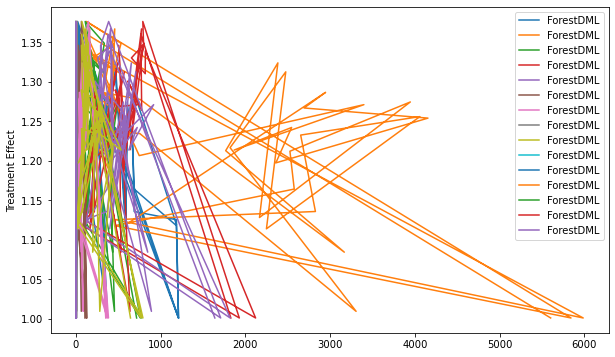

In [8]:
#得到因果效应
point_human = est_Forest_human.effect(X_human)
#lb, ub = est_Forest.effect_interval(, alpha=0.05)

print(point_human*100)
plt.figure(figsize=(10, 6))
plt.plot(X_human, point_human*100, label="ForestDML")

plt.ylabel("Treatment Effect")
plt.legend()

In [25]:
#验证因果推断的有效性

# Add Random Common Cause 
res_random = est_Forest_human.refute_estimate(method_name="random_common_cause")
print(res_random,float(str(res_random).split("\n")[1].split(":")[1]),float(str(res_random).split("\n")[2].split(":")[1]))

# Add Unobserved Common Cause 
res_unobserved = est_Forest_human.refute_estimate(
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="linear",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.1,
    effect_strength_on_outcome=0.1,
)
print(res_unobserved,float(str(res_unobserved).split("\n")[1].split(":")[1]),float(str(res_unobserved).split("\n")[2].split(":")[1]))

#Replace Treatment with a Random (Placebo) Variable
res_placebo = est_Forest_human.refute_estimate(
    method_name="placebo_treatment_refuter", placebo_type="permute", 
    num_simulations=3
)
print(res_placebo,float(str(res_placebo).split("\n")[1].split(":")[1]),float(str(res_placebo).split("\n")[2].split(":")[1]))
# Remove a Random Subset of the Data
res_subset = est_Forest_human.refute_estimate(
    method_name="data_subset_refuter", subset_fraction=0.8, 
    num_simulations=3)
print(res_subset,float(str(res_subset).split("\n")[1].split(":")[1]),float(str(res_subset).split("\n")[2].split(":")[1]))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Refute: Add a Random Common Cause
Estimated effect:0.012124252471109586
New effect:0.010475846117004193
 0.012124252471109586 0.010475846117004193


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Refute: Add an Unobserved Common Cause
Estimated effect:0.012124252471109586
New effect:0.006885512707318527
 0.012124252471109586 0.006885512707318527


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Refute: Use a Placebo Treatment
Estimated effect:0.012124252471109586
New effect:0.0004508127550935822
p value:1.576884044389105e-11
 0.012124252471109586 0.0004508127550935822


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Refute: Use a subset of data
Estimated effect:0.012124252471109586
New effect:0.009372095846975773
p value:0.2520325920522025
 0.012124252471109586 0.009372095846975773


In [22]:
float(str(res_subset).split("\n")[2].split(":")[1])

'0.012124252471109586'

In [ ]:
#将得到的因果效应加入到data中

ate_list = point_human.tolist()

data['human_Treatment_effect'] = ate_list

# for i in range(2074):
#   print(ate_list[i])

data

,land,square,hunman,factory,scholl,oddice,shop,hospital,hotel,theater,park,restaurant,edu,Health care,life,scenry,transport,score,years,human_Treatment_effect
0,浦东新区,1210.41,4545,5602,716,1828,1639,106,352,5,643.81,0.200993,0.212796,0.206629,0.236547,0.191260,0.244190,884.338339,2018,0.007005
1,黄浦区,20.46,32072,125,109,766,378,64,147,14,67.59,0.060096,0.058717,0.054109,0.076773,0.105820,0.153166,738.275545,2018,0.010004
2,徐汇区,54.76,19825,519,333,776,293,121,93,3,136.88,0.065919,0.107630,0.070709,0.090514,0.059377,0.221342,561.198377,2018,0.008840
3,长宁区,38.30,17982,205,122,613,226,35,103,2,136.00,0.055880,0.050755,0.058313,0.067858,0.055850,0.157478,520.949617,2018,0.011372
4,静安区,36.88,28953,455,157,754,400,67,166,8,106.08,0.070848,0.071762,0.071571,0.096190,0.058397,0.204850,650.262566,2018,0.008981
5,普陀区,54.83,23387,398,203,518,419,26,71,3,86.48,0.056465,0.054982,0.060523,0.086370,0.034098,0.186958,533.249085,2018,0.010913
6,虹口区,23.48,34315,155,117,464,264,29,80,6,62.24,0.044818,0.039006,0.043061,0.073912,0.033902,0.132417,578.936297,2018,0.011771
7,杨浦区,60.73,21561,759,388,512,280,46,36,3,221.51,0.056707,0.080736,0.066020,0.071817,0.039193,0.179089,523.760032,2018,0.009634
8,闵行区,370.75,6850,3167,433,531,847,61,65,5,197.65,0.096979,0.093936,0.083913,0.111149,0.072506,0.337214,616.288206,2018,0.007258
9,宝山区,270.99,7493,1767,212,298,557,30,38,2,425.99,0.070848,0.054282,0.063110,0.015689,0.040172,0.193856,525.315845,2018,0.010356


In [123]:
# Define estimator inputs
#定义第二个关于"factory"的因果效应
Y = data["score"]  # outcome of interest
#print('Y的类型：',type(Y))
T_factory = data["factory"]  # intervention, or treatment
X_factory = data.drop(columns=["score", "factory","land","years"])


In [137]:
#定义factory模型，
est_Forest_factory = CausalForestDML(
    model_y=GradientBoostingRegressor(),
    model_t=GradientBoostingRegressor(),
    criterion='mse', n_estimators=1000,
                       min_impurity_decrease=0.001,
    #model_final=Lasso(alpha=0.1, fit_intercept=False),
    featurizer=PolynomialFeatures(degree=2, include_bias=False),
    random_state=123
  )
est_Forest_factory = est_Forest_factory.dowhy.fit(Y, T=T_factory, X=X_factory)

print('score:',est_Forest_factory.score)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


score: <bound method _RLearner.score of <econml.dml.causal_forest.CausalForestDML object at 0x7f16fcda3250>>


[8.37696587 8.10357691 7.8232987  5.4201133  8.24342117 5.36648432
 5.60131573 6.23037752 7.77558233 4.23266635 6.08580755 2.61584479
 5.14994242 4.10449828 3.24460304 2.32932634 8.39998443 7.50325504
 6.8850165  4.01712998 8.05732347 4.29475919 4.92422819 5.10462329
 7.88472706 4.12610847 6.66631741 2.2848606  5.06740191 3.99957958
 2.58207521 2.65601832 8.43294831 8.18920061 6.28041167 5.95924662
 7.89497504 4.8721403  6.48058337 4.78689529 7.23918152 4.2178491
 6.95718613 3.29651735 4.63169856 4.42308342 5.33631426 2.42431512]


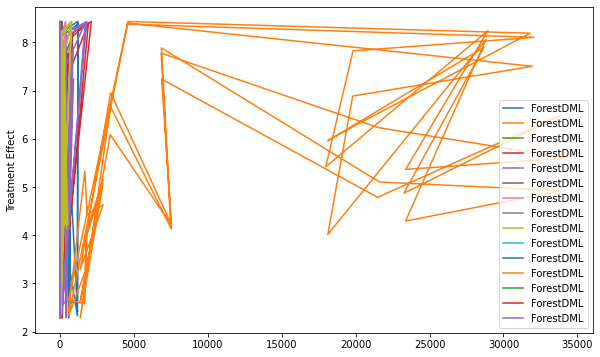

In [138]:
#得到因果效应
points_factory = est_Forest_factory.effect(X_factory)
#lb, ub = est_Forest.effect_interval(, alpha=0.05)

print(points_factory*100)
plt.figure(figsize=(10, 6))
plt.plot(X_factory, points_factory*100, label="ForestDML")

plt.ylabel("Treatment Effect")
plt.legend()

In [125]:
#验证因果推断的有效性

# Add Random Common Cause 
res_random = est_Forest_factory.refute_estimate(method_name="random_common_cause")
print(res_random)

# Add Unobserved Common Cause 
res_unobserved = est_Forest_factory.refute_estimate(
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="linear",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.1,
    effect_strength_on_outcome=0.1,
)
print(res_unobserved)

#Replace Treatment with a Random (Placebo) Variable
res_placebo = est_Forest_factory.refute_estimate(
    method_name="placebo_treatment_refuter", placebo_type="permute", 
    num_simulations=3
)
print(res_placebo)
# Remove a Random Subset of the Data
res_subset = est_Forest_factory.refute_estimate(
    method_name="data_subset_refuter", subset_fraction=0.8, 
    num_simulations=3)
print(res_subset)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Refute: Add a Random Common Cause
Estimated effect:0.05476647978835578
New effect:0.05716023657572383



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Refute: Add an Unobserved Common Cause
Estimated effect:0.05476647978835578
New effect:0.060881605473843185



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Refute: Use a Placebo Treatment
Estimated effect:0.05476647978835578
New effect:0.000453926522248624
p value:0.47605164091909463



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Refute: Use a subset of data
Estimated effect:0.05476647978835578
New effect:0.0012694712772036694
p value:0.0



In [140]:
#将得到的因果效应加入到data中

ate_list = points_factory.tolist()

data['factory_Treatment_effect'] = ate_list

# for i in range(2074):
#   print(ate_list[i])

data

,land,square,hunman,factory,scholl,oddice,shop,hospital,hotel,theater,park,restaurant,edu,Health care,life,scenry,transport,score,years,factory_Treatment_effect
0,浦东新区,1210.41,4545,5602,716,1828,1639,106,352,5,643.81,0.200993,0.212796,0.206629,0.236547,0.191260,0.244190,884.338339,2018,0.083770
1,黄浦区,20.46,32072,125,109,766,378,64,147,14,67.59,0.060096,0.058717,0.054109,0.076773,0.105820,0.153166,738.275545,2018,0.081036
2,徐汇区,54.76,19825,519,333,776,293,121,93,3,136.88,0.065919,0.107630,0.070709,0.090514,0.059377,0.221342,561.198377,2018,0.078233
3,长宁区,38.30,17982,205,122,613,226,35,103,2,136.00,0.055880,0.050755,0.058313,0.067858,0.055850,0.157478,520.949617,2018,0.054201
4,静安区,36.88,28953,455,157,754,400,67,166,8,106.08,0.070848,0.071762,0.071571,0.096190,0.058397,0.204850,650.262566,2018,0.082434
5,普陀区,54.83,23387,398,203,518,419,26,71,3,86.48,0.056465,0.054982,0.060523,0.086370,0.034098,0.186958,533.249085,2018,0.053665
6,虹口区,23.48,34315,155,117,464,264,29,80,6,62.24,0.044818,0.039006,0.043061,0.073912,0.033902,0.132417,578.936297,2018,0.056013
7,杨浦区,60.73,21561,759,388,512,280,46,36,3,221.51,0.056707,0.080736,0.066020,0.071817,0.039193,0.179089,523.760032,2018,0.062304
8,闵行区,370.75,6850,3167,433,531,847,61,65,5,197.65,0.096979,0.093936,0.083913,0.111149,0.072506,0.337214,616.288206,2018,0.077756
9,宝山区,270.99,7493,1767,212,298,557,30,38,2,425.99,0.070848,0.054282,0.063110,0.015689,0.040172,0.193856,525.315845,2018,0.042327
